In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['axes.facecolor'] = '#dae5e4'
plt.rcParams['figure.facecolor'] = '#dae5e4'

primary = '#0a7c80'
secondary = '#b3dad9'

red_primary = '#b0554b'
red_secondary = '#d1aeae'

## Starting Values

In [2]:
### in microM ###
substrate_concentrations = {
    "GSH": 2970,
    "GSSG": 30,
    "NADPH": 100,
    "H2O2": 1
}

### in microM ###
enzyme_concentrations = {
    "gpx": 2,
    "gr": 0.05,
}

dt = 1 # time increment in seconds
time_total = 300 # total time for simulation
time = np.arange(0, time_total, dt)

## Ensemble Modelling - distributions of kinetic constants

In [3]:
# random sampling from ensemble model
nsamples = 10000
kcat_gpx = np.random.lognormal(6.0605, 0.77127, nsamples)
km_gpx_gsh = np.random.lognormal(6.4663, 1.0753, nsamples)
km_gpx_h2o2 = np.random.lognormal(8.5495, 0.65608, nsamples)

kcat_gr = np.random.lognormal(4, 1.3473, nsamples)
km_gr_gssg = np.random.lognormal(4.1601, 0.39181, nsamples)
km_gr_nadph = np.random.lognormal(3.2816, 0.97294, nsamples)

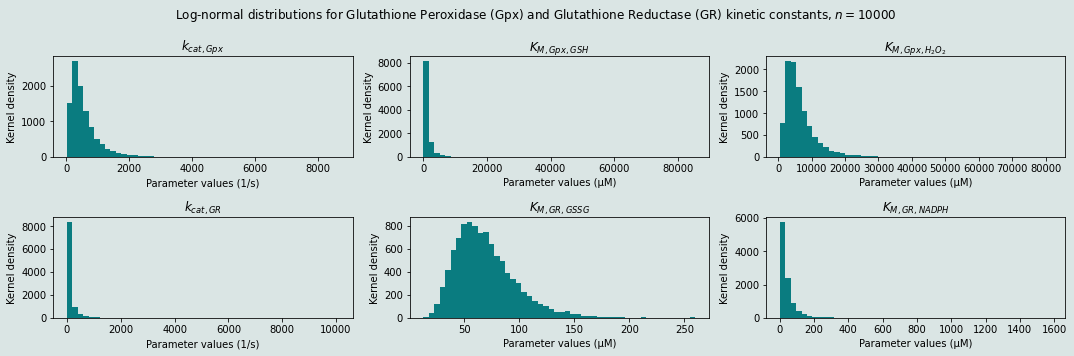

In [4]:
nbins = 50
fig, axs = plt.subplots(2, 3)
plt.rcParams['figure.figsize'] = [15, 8]

axs[0, 0].hist(kcat_gpx, nbins, color=primary)
axs[0, 0].title.set_text('$k_{cat, Gpx}$')
axs[0, 0].set_xlabel('Parameter values (1/s)')
axs[0, 0].set_ylabel('Kernel density')

axs[0, 1].hist(km_gpx_gsh, nbins, color=primary)
axs[0, 1].title.set_text('$K_{M, Gpx, GSH}$')
axs[0, 1].set_xlabel('Parameter values (μM)')
axs[0, 1].set_ylabel('Kernel density')

axs[0, 2].hist(km_gpx_h2o2, nbins, color=primary)
axs[0, 2].title.set_text('$K_{M, Gpx, H_2O_2}$')
axs[0, 2].set_xlabel('Parameter values (μM)')
axs[0, 2].set_ylabel('Kernel density')

axs[1, 0].hist(kcat_gr, nbins, color=primary)
axs[1, 0].title.set_text('$k_{cat, GR}$')
axs[1, 0].set_xlabel('Parameter values (1/s)')
axs[1, 0].set_ylabel('Kernel density')

axs[1, 1].hist(km_gr_gssg, nbins, color=primary)
axs[1, 1].title.set_text('$K_{M, GR, GSSG}$')
axs[1, 1].set_xlabel('Parameter values (μM)')
axs[1, 1].set_ylabel('Kernel density')

axs[1, 2].hist(km_gr_nadph, nbins, color=primary)
axs[1, 2].title.set_text('$K_{M, GR, NADPH}$')
axs[1, 2].set_xlabel('Parameter values (μM)')
axs[1, 2].set_ylabel('Kernel density')

fig.suptitle('Log-normal distributions for Glutathione Peroxidase (Gpx) and Glutathione Reductase (GR) kinetic constants, $n = 10000$')
fig.tight_layout()

# fig.savefig('ensemble_modelling_dists.jpg')

## Velocity Reactions

Based on Michaelis Menten saturation kinetics of a rapid equilibrium bisubstrate reaction

In [5]:
###
# Calculate the velocity of the glutathione peroxidase catalysed reaction,
# given [Gpx], [GSH] and [H2O2] and Michaelis Menten constants for Gpx
###
def velocityGPX(kcat_GPX, kM_GPX_GSH, kM_GPX_H2O2, conc_GPX, conc_GSH, conc_H2O2):
    return (kcat_GPX*conc_GPX*conc_GSH*conc_H2O2)/(conc_GSH*conc_H2O2+kM_GPX_GSH*conc_H2O2+kM_GPX_H2O2*conc_GSH+kM_GPX_H2O2*kM_GPX_GSH)

###
# Calculate the velocity of the glutathione reductase catalysed reaction,
# given [GR], [GSSG] and [NADPH] and Michaelis Menten constants for GR
###
def velocityGR(kcat_GR, kM_GR_GSSG, kM_GR_NADPH, conc_GR, conc_GSSG, conc_NADPH):
    return (kcat_GR*conc_GR*conc_GSSG*conc_NADPH)/(conc_GSSG*conc_NADPH+kM_GR_GSSG*conc_NADPH+kM_GR_NADPH*conc_GSSG+kM_GR_NADPH*kM_GR_GSSG)

## Simulation functions

In [6]:
###
#  Simulates the system.
#  From the initial substrate and enzyme concentrations, determine the change in
#  substrate concentrations given the velocity of each reaction. Repeat at intervals
#  dt for an overall duration time_total.
###
def simulate(dt, time_total, kinetic_constants, init_substrate_conc, enzyme_conc):
    if (dt <= 0):
        print("Time increment must be positive")
        return
    
    nsteps = int(time_total / dt)
    
    gsh = np.zeros(nsteps, dtype="float32")
    gssg = np.zeros(nsteps, dtype="float32")
    h2o2 = np.zeros(nsteps, dtype="float32")

    gsh[0] = init_substrate_conc["GSH"]
    gssg[0] = init_substrate_conc["GSSG"]
    h2o2[0] = init_substrate_conc["H2O2"]
    
    nadph = init_substrate_conc["NADPH"]
    
    ec = enzyme_conc
    k_gpx = kinetic_constants["gpx"]
    k_gr = kinetic_constants["gr"]
    
    for t in range(1, nsteps):
        vGpx = velocityGPX(k_gpx["kcat"], k_gpx["kM"]["GSH"], k_gpx["kM"]["H2O2"], ec["gpx"], gsh[t-1], h2o2[t-1])
        vGR = velocityGR(k_gr["kcat"], k_gr["kM"]["GSSG"], k_gr["kM"]["NADPH"], ec["gr"], gssg[t-1], nadph)
        
        gsh[t] = max(gsh[t-1] + 2*(vGR - vGpx)*dt, 0)
        gssg[t] = max(gssg[t-1] + (vGpx - vGR)*dt, 0)
        h2o2[t] = max(h2o2[t-1] - vGpx*dt, 0)
        
    return gsh, gssg, h2o2

###
#  Given starting substrate and enzyme concentrations, simulate the reaction multiple times using
#  a range of kinetic values over separate runs (values determined by random sampling from a given distribution)
###
def ensemble_sim (subs_conc, enz_conc):

    gsh_sampled = []
    gssg_sampled = []
    h2o2_sampled = []
    for i in range(nsamples):
        if (i % 1000 == 0):
            print('t = ' + str(i))

        ### in microM (Km) or 1/s (Kcat) ###
        kinetic_constants = {
            "gr": {
                "kcat": kcat_gr[i],
                "kM": {
                    "GSSG": km_gr_gssg[i],
                    "NADPH": km_gr_nadph[i]
                }
            },
            "gpx": {
                "kcat": kcat_gpx[i],
                "kM": {
                    "GSH": km_gpx_gsh[i],
                    "H2O2": km_gpx_h2o2[i]
                }
            }
        }

        gsh_arr, gssg_arr, h2o2_arr = simulate(dt, time_total, kinetic_constants, subs_conc, enz_conc)

        gsh_sampled.append(gsh_arr)
        gssg_sampled.append(gssg_arr)
        h2o2_sampled.append(h2o2_arr)
        
        
    print('t = ' + str(i + 1))

    return gsh_sampled, gssg_sampled, h2o2_sampled

## Summarising and plotting functions

In [7]:
# Calculates the Ehc potential (mV) from the glutathione pool
def GSHpotential (gsh, gssg):
    #convert to moles
    gsh = gsh/1000000
    gssg = gssg/1000000
    return -240+30*np.log(gssg/(gsh**2))

# Population statistics:
def summarise (values):
    sort_val = np.sort(values, axis = 0)
    summ = {}
    summ["mean"] = np.mean(sort_val, axis = 0)
    summ["med"] = sort_val[nsamples//2, :]
    summ["25"] = sort_val[nsamples//4, :]
    summ["75"] = sort_val[3*nsamples//4, :]
    
    return summ

# Plot quartiles
def plot_quartiles (gsh_stats, gssg_stats, h2o2_stats, title="Substrate concentration over time"):
    figure, axes = plt.subplots(nrows=1, ncols=3)
    axes[0].plot(time, gsh_stats["med"], color=primary)
    axes[0].fill_between(time, gsh_stats["25"], gsh_stats["75"], color=secondary)
    axes[0].title.set_text('GSH over time')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Concentration (μM)')
    
    axes[1].plot(time, gssg_stats["med"], color=primary, label="Median")
    axes[1].fill_between(time, gssg_stats["25"], gssg_stats["75"], color=secondary, label='Interquartile Range')
    axes[1].title.set_text("GSSG over time")
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Concentration (μM)')
    
    axes[2].plot(time, h2o2_stats["med"], color=red_primary)
    axes[2].fill_between(time, h2o2_stats["25"], h2o2_stats["75"], color=red_secondary)
    axes[2].title.set_text("H$_2$O$_2$ over time")
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Concentration (μM)')
    
    figure.suptitle(title)
    figure.legend()
    figure.savefig(title+'.jpg')

def plot_ehc(ehc_med, subtitle=""):
    plt.plot(time, ehc_med, color=primary, label="Median")
    plt.suptitle("Half cell redox potential $E_{hc}$ for the GSH/GSSG couple")
    if subtitle != "":
        plt.title(subtitle)
    plt.xlabel('Time (s)')
    plt.ylabel('Half cell potential $E_{hc}$ (mV)')
    
    plt.axhline(y=max(ehc_med), color=red_primary, linestyle='--')
    plt.text(time[int(0.8*len(time))], max(ehc_med) - 15, '$E_{hc}$ = '+str(int(max(ehc_med))), color=red_primary, size='13')
    
    plt.legend()
    plt.savefig(subtitle+'_GSH_Ehc.jpg')
    plt.show()


# Simulation Runs
### Basic system; low ROS

In [8]:
# Run
gsh_sampled, gssg_sampled, h2o2_sampled = ensemble_sim(substrate_concentrations, enzyme_concentrations)

# Flux summaries
gsh_stats = summarise(gsh_sampled)
gssg_stats = summarise(gssg_sampled)
h2o2_stats = summarise(h2o2_sampled)

t = 0
t = 1000
t = 2000
t = 3000
t = 4000
t = 5000
t = 6000
t = 7000
t = 8000
t = 9000
t = 10000


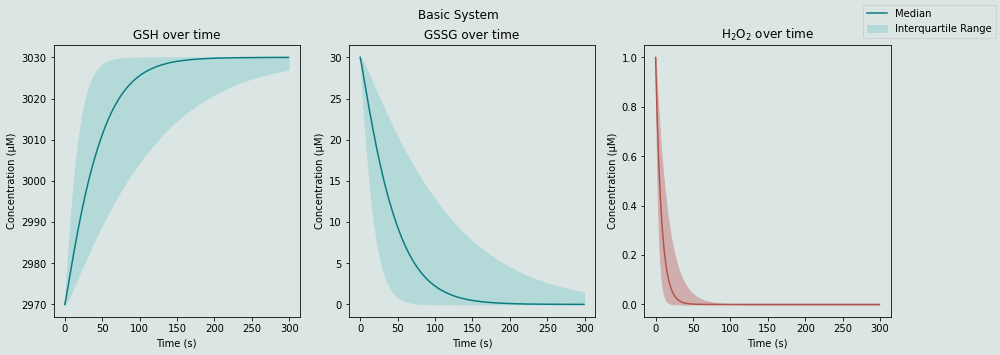

In [9]:
plt.rcParams['figure.figsize'] = [15, 5]
plot_quartiles (gsh_stats, gssg_stats, h2o2_stats, title="Basic System")

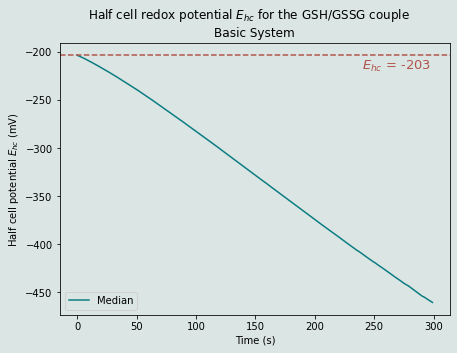

In [10]:
# Half-cell Potential
Ehc_med = GSHpotential(gsh_stats["med"], gssg_stats["med"])

plt.rcParams['figure.figsize'] = [7, 5]
plot_ehc(Ehc_med, subtitle="Basic System")

### Increased H<sub>2</sub>O<sub>2</sub> load Run
100 μM of H<sub>2</sub>O<sub>2</sub> in system at start

In [11]:
# Increased H2O2 load
sub_conc_h2o2 = {
    "GSH": 2970,
    "GSSG": 30,
    "NADPH": 50,
    "H2O2": 100
}

### in microM ###
enzyme_concentrations = {
    "gpx": 2,
    "gr": 0.05,
}

gsh_sampled, gssg_sampled, h2o2_sampled = ensemble_sim(sub_conc_h2o2, enzyme_concentrations)

# Results, inc. H2O2 load
gsh_stats = summarise(gsh_sampled)
gssg_stats = summarise(gssg_sampled)
h2o2_stats = summarise(h2o2_sampled)

t = 0
t = 1000
t = 2000
t = 3000
t = 4000
t = 5000
t = 6000
t = 7000
t = 8000
t = 9000
t = 10000


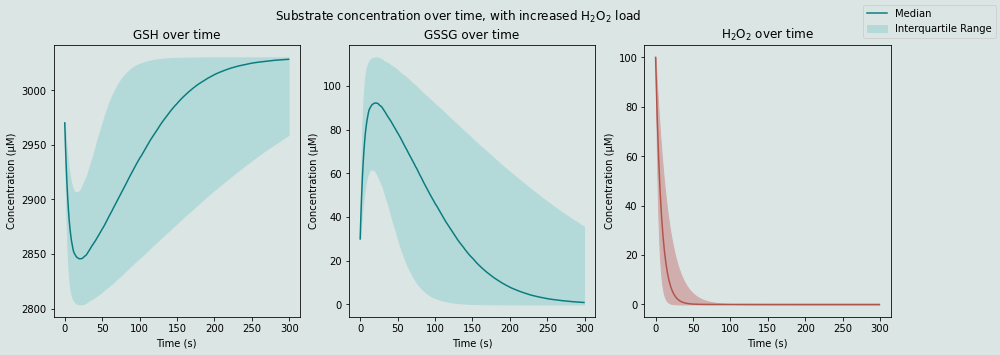

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
plot_quartiles (gsh_stats, gssg_stats, h2o2_stats, \
                title="Substrate concentration over time, with increased H$_2$O$_2$ load")

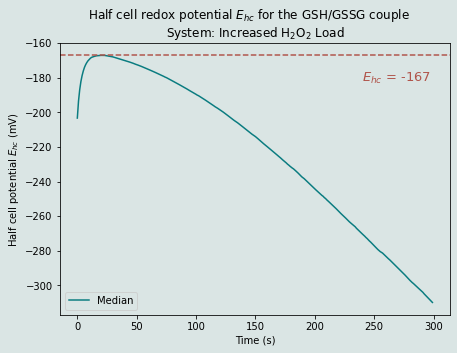

In [13]:
Ehc_med = GSHpotential(gsh_stats["med"], gssg_stats["med"])

plt.rcParams['figure.figsize'] = [7, 5]
plot_ehc(Ehc_med, subtitle="System: Increased H$_2$O$_2$ Load")

### Increased GSH Content and Increased H<sub>2</sub>O<sub>2</sub> Load Run
4.9mM GSH/0.05mM GSSG, and 100 μM of H<sub>2</sub>O<sub>2</sub> in system at start

In [14]:
# Increased GSH load
sub_conc_h2o2 = {
    "GSH": 4900,
    "GSSG": 50,
    "NADPH": 100,
    "H2O2": 100
}

### in microM ###
enzyme_concentrations = {
    "gpx": 2,
    "gr": 0.05,
}

gsh_sampled, gssg_sampled, h2o2_sampled = ensemble_sim(sub_conc_h2o2, enzyme_concentrations)

# Results, inc. H2O2 load
gsh_stats = summarise(gsh_sampled)
gssg_stats = summarise(gssg_sampled)
h2o2_stats = summarise(h2o2_sampled)

t = 0
t = 1000
t = 2000
t = 3000
t = 4000
t = 5000
t = 6000
t = 7000
t = 8000
t = 9000
t = 10000


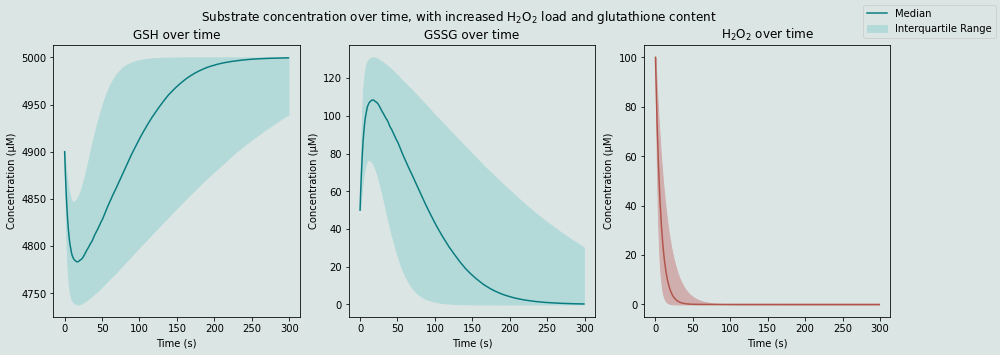

In [15]:
plt.rcParams['figure.figsize'] = [15, 5]
plot_quartiles (gsh_stats, gssg_stats, h2o2_stats, \
                title="Substrate concentration over time, with increased H$_2$O$_2$ load and glutathione content")

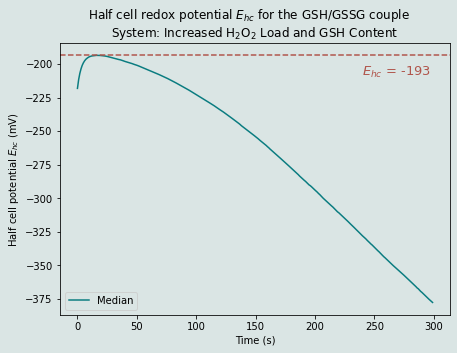

In [16]:
Ehc_med = GSHpotential(gsh_stats["med"], gssg_stats["med"])

plt.rcParams['figure.figsize'] = [7, 5]
plot_ehc(Ehc_med, subtitle="System: Increased H$_2$O$_2$ Load and GSH Content")

### Increased H<sub>2</sub>O<sub>2</sub> load Run and [Gpx] = [GR]
100 μM of H<sub>2</sub>O<sub>2</sub> in system at start, with [Gpx] = [GR] = 0.2

In [17]:
# Increased H2O2 load
sub_conc_h2o2 = {
    "GSH": 2970,
    "GSSG": 30,
    "NADPH": 100,
    "H2O2": 100
}

### in microM ###
enzyme_concentrations = {
    "gpx": 0.2,
    "gr": 0.2,
}

gsh_sampled, gssg_sampled, h2o2_sampled = ensemble_sim(sub_conc_h2o2, enzyme_concentrations)

# Results, inc. H2O2 load
gsh_stats = summarise(gsh_sampled)
gssg_stats = summarise(gssg_sampled)
h2o2_stats = summarise(h2o2_sampled)

t = 0
t = 1000
t = 2000
t = 3000
t = 4000
t = 5000
t = 6000
t = 7000
t = 8000
t = 9000
t = 10000


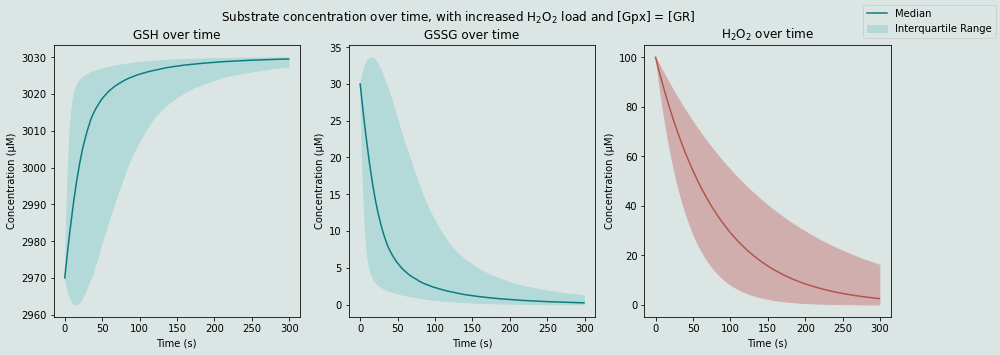

In [18]:
plt.rcParams['figure.figsize'] = [15, 5]
plot_quartiles (gsh_stats, gssg_stats, h2o2_stats, \
                title="Substrate concentration over time, with increased H$_2$O$_2$ load and [Gpx] = [GR]")

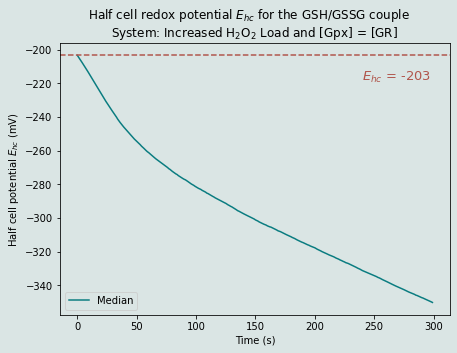

In [19]:
Ehc_med = GSHpotential(gsh_stats["med"], gssg_stats["med"])

plt.rcParams['figure.figsize'] = [7, 5]
plot_ehc(Ehc_med, subtitle="System: Increased H$_2$O$_2$ Load and [Gpx] = [GR]")